In [1]:
!pip install cairosvg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 758.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.6 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cairosvg

def convert_svg_to_png(input_svg_path, output_png_path):
    try:
        cairosvg.svg2png(url=input_svg_path, write_to=output_png_path)
        print(f"Successfully converted {input_svg_path} to {output_png_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

input_svg_path = r"/content/isolated_sol.csv"
output_png_path = r"/content/isolated_sol.png"

# Convert SVG to PNG
convert_svg_to_png(input_svg_path, output_png_path)

An error occurred: <urlopen error [Errno 2] No such file or directory: '/content/isolated_sol.csv'>


Loaded data:
[[  0.           0.         109.14299774 125.58000183]
 [  0.           0.         110.15747833 125.49578094]
 [  0.           0.         111.17194366 125.40398407]
 ...
 [  2.           0.           5.6753335    1.34307408]
 [  2.           0.           7.1833334    1.5595926 ]
 [  2.           0.           8.69999981   1.41700006]]
Output image saved at regularise.png


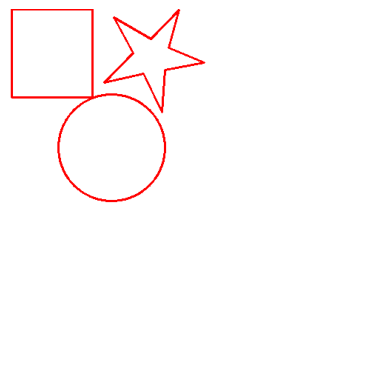

In [4]:
def read_csv(csv_path):
    try:
        np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
        print("Loaded data:")
        print(np_path_XYs)

        path_XYs = []
        for i in np.unique(np_path_XYs[:, 0]):
            npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
            XYs = []
            for j in np.unique(npXYs[:, 0]):
                XY = npXYs[npXYs[:, 0] == j][:, 1:]
                XYs.append(XY.astype(np.int32))
            path_XYs.append(XYs)

        return path_XYs

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def detect_shapes_refined_from_csv(csv_path, output_path):
    path_XYs = read_csv(csv_path)
    if not path_XYs:
        return

    output = np.ones((500, 500, 3), dtype=np.uint8) * 255

    for path_contours in path_XYs:
        for contour in path_contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            area = cv2.contourArea(contour)

            if area < 100:
                continue

            if len(approx) == 3:
                cv2.drawContours(output, [approx], -1, (0, 0, 255), 2)
            elif len(approx) == 4:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.95 <= aspect_ratio <= 1.05:
                    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)
                else:
                    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)
            elif len(approx) == 5:
                cv2.drawContours(output, [approx], -1, (0, 0, 255), 2)
            elif len(approx) > 5:
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)
                perimeter = cv2.arcLength(contour, True)
                circularity = 4 * np.pi * (area / (perimeter ** 2))
                if 0.7 < circularity < 1.3:
                    cv2.circle(output, center, radius, (0, 0, 255), 2)
                else:
                    cv2.drawContours(output, [approx], -1, (0, 0, 255), 2)

    cv2.imwrite(output_path, output)
    print(f"Output image saved at {output_path}")

csv_path = r"isolated.csv"
refined_output_image_path = r"regularise.png"


detect_shapes_refined_from_csv(csv_path, refined_output_image_path)

output_image = Image.open(refined_output_image_path)
plt.imshow(output_image)
plt.axis('off')
plt.show()